# Pre-processing

In this notebook, we will look at basic pre-processing of scRNA-seq data. We'll cover the topics of:  
- QC 
- Data normalization 

# Library imports

Install all packages for the tutorial

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os

#single cell library
import scanpy as sc

#doublet detection
import scrublet as scr


# Load data

10k Human peripheral blood mononuclear cells (PBMCs) of a healthy female donor aged 25-30 were obtained by 10x Genomics.

The data is an mtx directory with an `mtx` file (*i.e.* count matrix), two `tsv` files with barcodes (*i.e.* cell indices) and features (*i.e.* gene symbols). `Scanpy` unpacks the files (if the files are in `gz` archive format) and creates an `anndata` object with the `read_10x_mtx` function.

The data being used here was collected from: https://www.10xgenomics.com/datasets/10k-human-pbmcs-3-v3-1-chromium-x-with-intronic-reads-3-1-high

In [2]:
input_path = '/Users/sara.jimenez/Documents/scWorkshop/data/'

In [3]:
adata = sc.read_10x_mtx(input_path + 'filtered_feature_bc_matrix/')

In [4]:
adata

AnnData object with n_obs × n_vars = 11984 × 36601
    var: 'gene_ids', 'feature_types'

In [5]:
adata.obs

""
AAACCCAAGGCCCAAA-1
AAACCCAAGTAATACG-1
AAACCCAAGTCACACT-1
AAACCCACAAAGCGTG-1
AAACCCACAATCGAAA-1
...
TTTGTTGGTTGGATCT-1
TTTGTTGGTTTCTTAC-1
TTTGTTGTCCATTTCA-1
TTTGTTGTCTACACAG-1


In [6]:
adata.var

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression
...,...,...
AC141272.1,ENSG00000277836,Gene Expression
AC023491.2,ENSG00000278633,Gene Expression
AC007325.1,ENSG00000276017,Gene Expression
AC007325.4,ENSG00000278817,Gene Expression


# Basic pre-processing of data

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

We start with calculating the QC covariates: 

* total number of counts per cell
* number of expressed genes per cell
* fraction of mitochondrial reads per cell

In [7]:
sc.pp.calculate_qc_metrics(adata, inplace = True)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
adata

AnnData object with n_obs × n_vars = 11984 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## Visualize different metadata

The following is the library size distribution. Library size is defined as the total mRNA count in each cell.

Text(0, 0.5, 'Frequency')

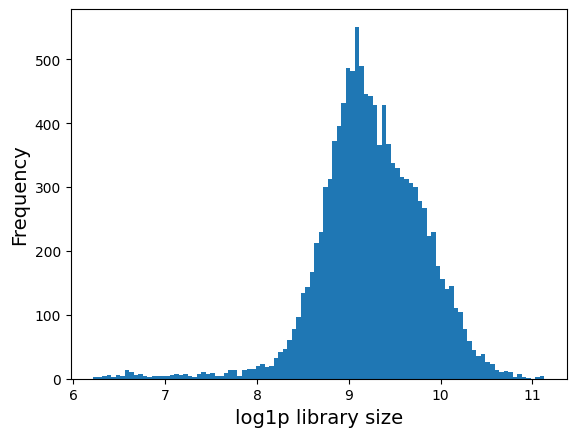

In [9]:
plt.hist(adata.obs['log1p_total_counts'], 100);
plt.xlabel('log1p library size', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)

The following is the distribution of number of genes expressed in each cell. It should be correlated with library size above.

Text(0, 0.5, 'Frequency')

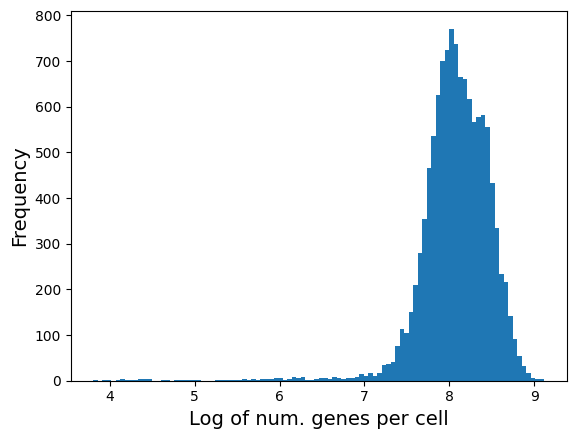

In [10]:
plt.hist(adata.obs['log1p_n_genes_by_counts'], bins = 100);
plt.xlabel('Log of num. genes per cell', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
#plt.title('Histogram of number of genes expressed in each cell', fontsize = 14)

Text(0.5, 1.0, 'Correlation = 0.951')

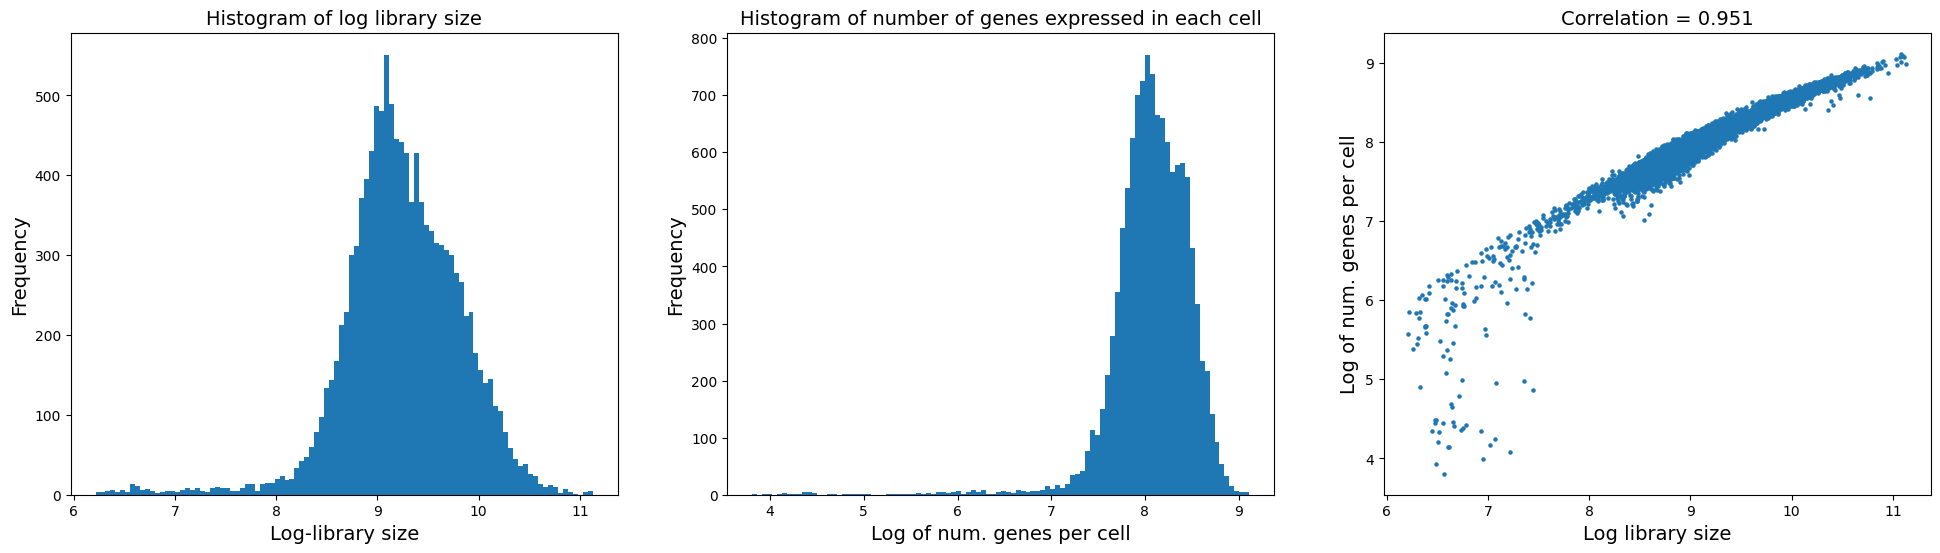

In [11]:
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(adata.obs['log1p_total_counts'], bins = 100);
ax.set_xlabel('Log-library size', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of log library size', fontsize = 14)

ax = fig.add_subplot(1, 3, 2)
ax.hist(adata.obs['log1p_n_genes_by_counts'], bins = 100);
ax.set_xlabel('Log of num. genes per cell', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of number of genes expressed in each cell', fontsize = 14)

ax = fig.add_subplot(1, 3, 3)
x = adata.obs['log1p_total_counts']
y = adata.obs['log1p_n_genes_by_counts']
ax.scatter(x, y, s = 5);
ax.set_ylabel('Log of num. genes per cell', fontsize = 14)
ax.set_xlabel('Log library size', fontsize = 14)
corr_coef = np.corrcoef(x, y)[0, 1]
ax.set_title('Correlation = ' + str(round(corr_coef, 3)), fontsize = 14)

## Visualize %MT

Compute the fraction of mitochondrial genes. Note: mitochondrial genes in human start with 'MT-'.

In [12]:
mt_genes = adata.var_names[adata.var_names.str.startswith('MT-')]

In [13]:
mt_genes

Index(['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3',
       'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object')

In [14]:
# compute the % of mito content by dividing the above result by library size
row_sum_adata_mito = np.sum(adata[:, mt_genes].X.toarray(), axis = 1)
adata.obs['mt_pct_content'] = row_sum_adata_mito/adata.obs['total_counts'] * 100

Text(0, 0.5, '% MT-content')

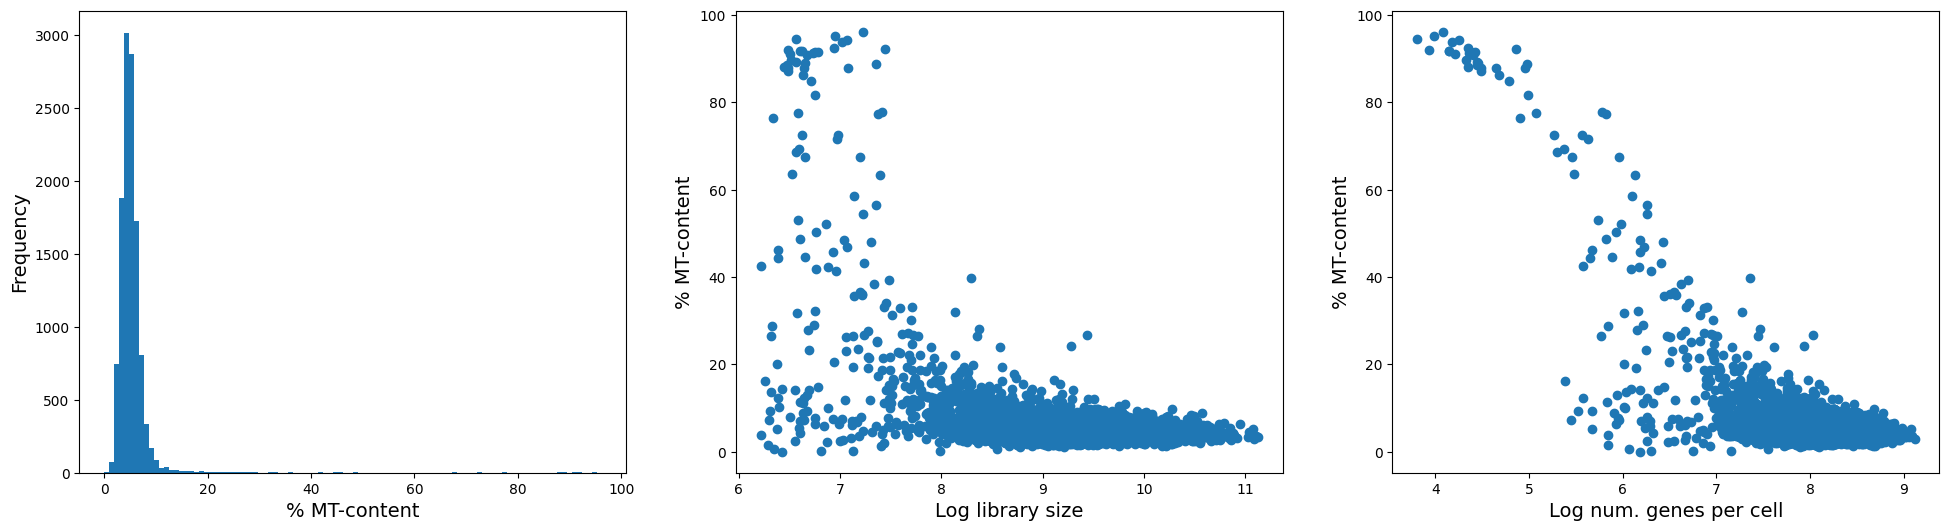

In [15]:
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(adata.obs['mt_pct_content'], 100);
ax.set_xlabel('% MT-content', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)

ax = fig.add_subplot(1, 3, 2)
ax.scatter(adata.obs['log1p_total_counts'], adata.obs['mt_pct_content']);
ax.set_xlabel('Log library size', fontsize = 14)
ax.set_ylabel('% MT-content', fontsize = 14)

ax = fig.add_subplot(1, 3, 3)
ax.scatter(adata.obs['log1p_n_genes_by_counts'], adata.obs['mt_pct_content']);
ax.set_xlabel('Log num. genes per cell', fontsize = 14)
ax.set_ylabel('% MT-content', fontsize = 14)

As you can see from the left plot, there are only very few cells with substantial MT content. And from the figure on the right, you can see that those cells with high MT-content are also the ones with low number of genes expressed (or library size). As such, we argue to remove these high MT-cells.

The following code removes cells with MT-content greater than 30%.

In [16]:
adata_clean = adata[adata.obs['mt_pct_content'] < 30, :]

In [17]:
adata_clean

View of AnnData object with n_obs × n_vars = 11908 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

Text(0, 0.5, 'Frequency')

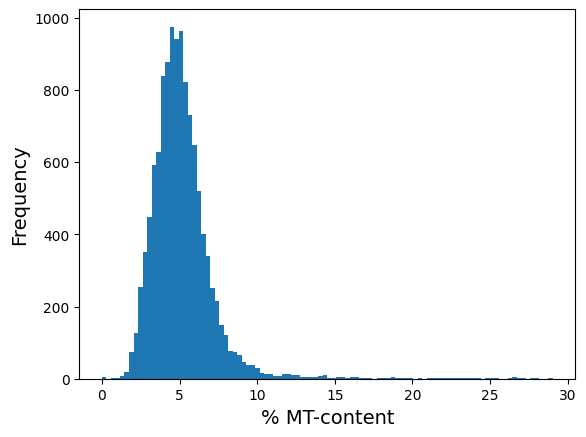

In [18]:
# just double check: there must be no cell with MT > 30
plt.hist(adata_clean.obs['mt_pct_content'], 100);
plt.xlabel('% MT-content', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)

NOTE: For the sake of exposition, we will continue with original `adata` (i.e. will not use `adata_clean`).

## Visualize gene metadata

Text(0.5, 1.0, 'Histogram of number of cells each gene is expressed in')

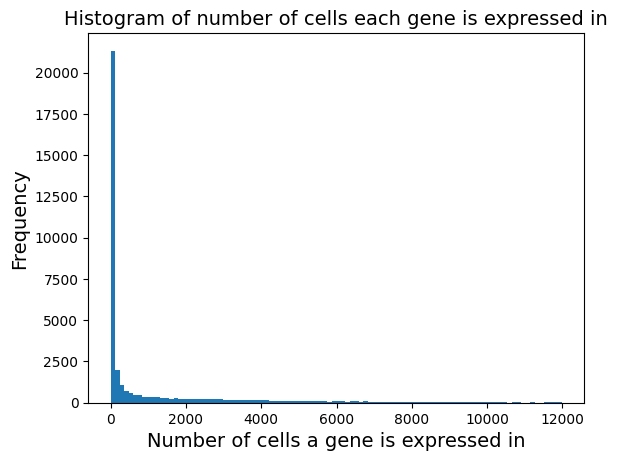

In [23]:
plt.hist(adata.var['n_cells_by_counts'], bins = 100);
plt.xlabel('Number of cells a gene is expressed in', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title('Histogram of number of cells each gene is expressed in', fontsize = 14)

We see that there are a lot of genes that are expressed in 0 cells. We can zoom in the plot to verify and we will remove them.

(0.0, 1000.0)

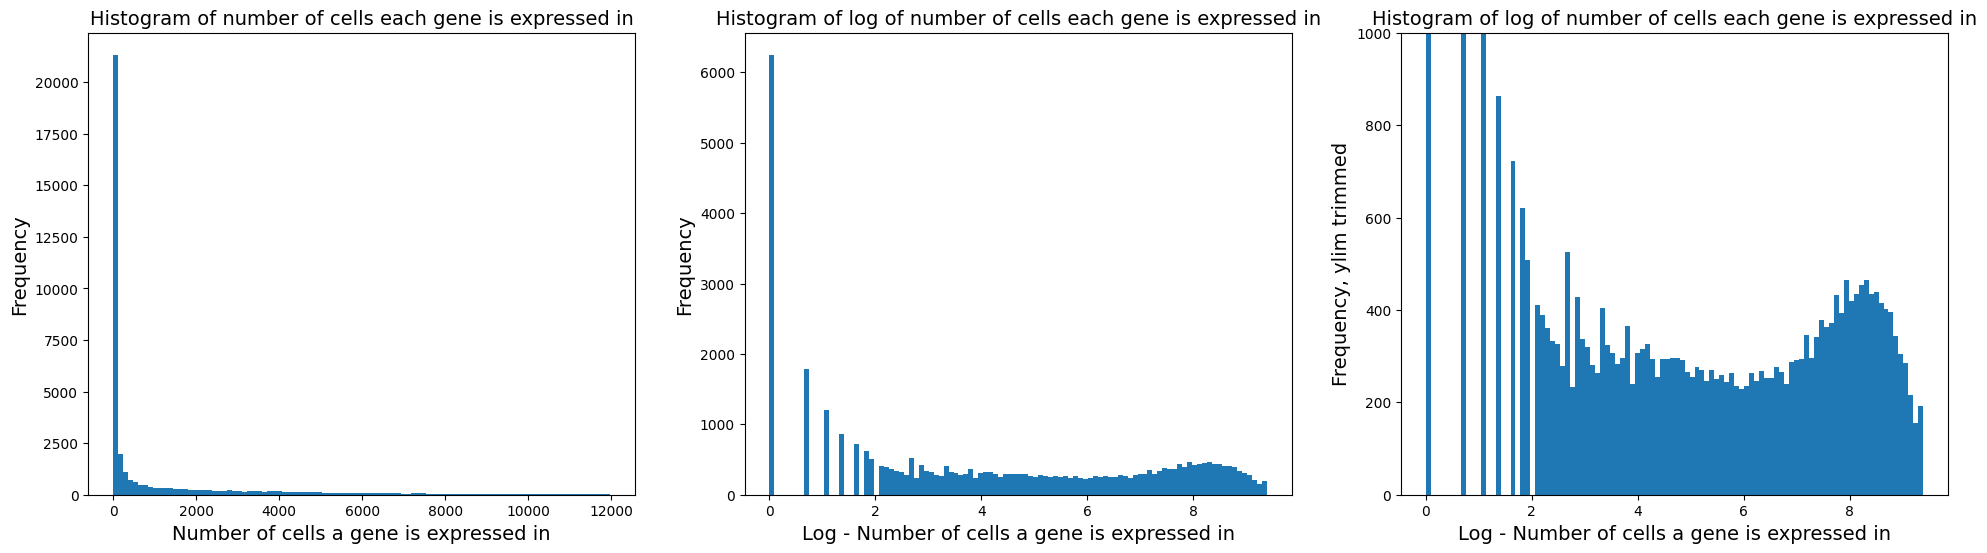

In [24]:
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(adata.var['n_cells_by_counts'], bins = 100);
ax.set_xlabel('Number of cells a gene is expressed in', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of number of cells each gene is expressed in', fontsize = 14)

ax = fig.add_subplot(1, 3, 2)
ax.hist(np.log(adata.var['n_cells_by_counts'] + 1), bins = 100);
ax.set_xlabel('Log - Number of cells a gene is expressed in', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)
ax.set_title('Histogram of log of number of cells each gene is expressed in', fontsize = 14)

ax = fig.add_subplot(1, 3, 3)
ax.hist(np.log(adata.var['n_cells_by_counts'] + 1), bins = 100);
ax.set_xlabel('Log - Number of cells a gene is expressed in', fontsize = 14)
ax.set_ylabel('Frequency, ylim trimmed', fontsize = 14)
ax.set_title('Histogram of log of number of cells each gene is expressed in', fontsize = 14)
ax.set_ylim([0, 1000])

Remove lowly expressed genes:

In [25]:
sc.pp.filter_genes(adata, min_cells = np.exp(4))

In [26]:
adata

AnnData object with n_obs × n_vars = 11984 × 17698
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

# Other QC metrics

## Ribosomal RNA content

In [27]:
# Identify ribo-genes
ribo_genes = adata.var_names[adata.var_names.str.startswith(('RPS', 'RPL'))]
print(ribo_genes)

Index(['RPL22', 'RPL11', 'RPS6KA1', 'RPS8', 'RPL5', 'RPS27', 'RPS6KC1', 'RPS7',
       'RPS27A', 'RPL31', 'RPL37A', 'RPL32', 'RPL15', 'RPSA', 'RPL14', 'RPL29',
       'RPL24', 'RPL22L1', 'RPL39L', 'RPL35A', 'RPL9', 'RPL34-AS1', 'RPL34',
       'RPS3A', 'RPL37', 'RPS23', 'RPS14', 'RPL26L1', 'RPS18', 'RPS10-NUDT3',
       'RPS10', 'RPL10A', 'RPL7L1', 'RPS12', 'RPS6KA2', 'RPS20', 'RPL7',
       'RPL30', 'RPL8', 'RPS6', 'RPL35', 'RPL12', 'RPL7A', 'RPS24', 'RPLP2',
       'RPL27A', 'RPS13', 'RPS6KA4', 'RPS6KB2', 'RPS6KB2-AS1', 'RPS3', 'RPS25',
       'RPS26', 'RPL41', 'RPL6', 'RPLP0', 'RPL21', 'RPS29', 'RPL36AL',
       'RPS6KL1', 'RPS6KA5', 'RPS27L', 'RPL4', 'RPLP1', 'RPS17', 'RPS2',
       'RPS15A', 'RPL13', 'RPL26', 'RPL23A', 'RPL23', 'RPL19', 'RPL27',
       'RPS6KB1', 'RPL38', 'RPL17', 'RPS15', 'RPL36', 'RPS28', 'RPL18A',
       'RPS16', 'RPS19', 'RPL18', 'RPL13A', 'RPS11', 'RPS9', 'RPL28', 'RPS5',
       'RPS21', 'RPL3', 'RPS19BP1', 'RPS6KA3', 'RPS4X', 'RPS6KA6', 'RPL36A',
       'RPL

In [28]:
# now we need the row sum of the subsetted data to compute % ribo content
row_sum_adata_ribo = np.sum(adata[:, ribo_genes].X.toarray(), axis = 1)

In [29]:
# compute the % of ribo content by dividing the above result by library size
adata.obs['ribo_pct_content'] = row_sum_adata_ribo/adata.obs['total_counts'] * 100

Text(0, 0.5, '% Ribo-content')

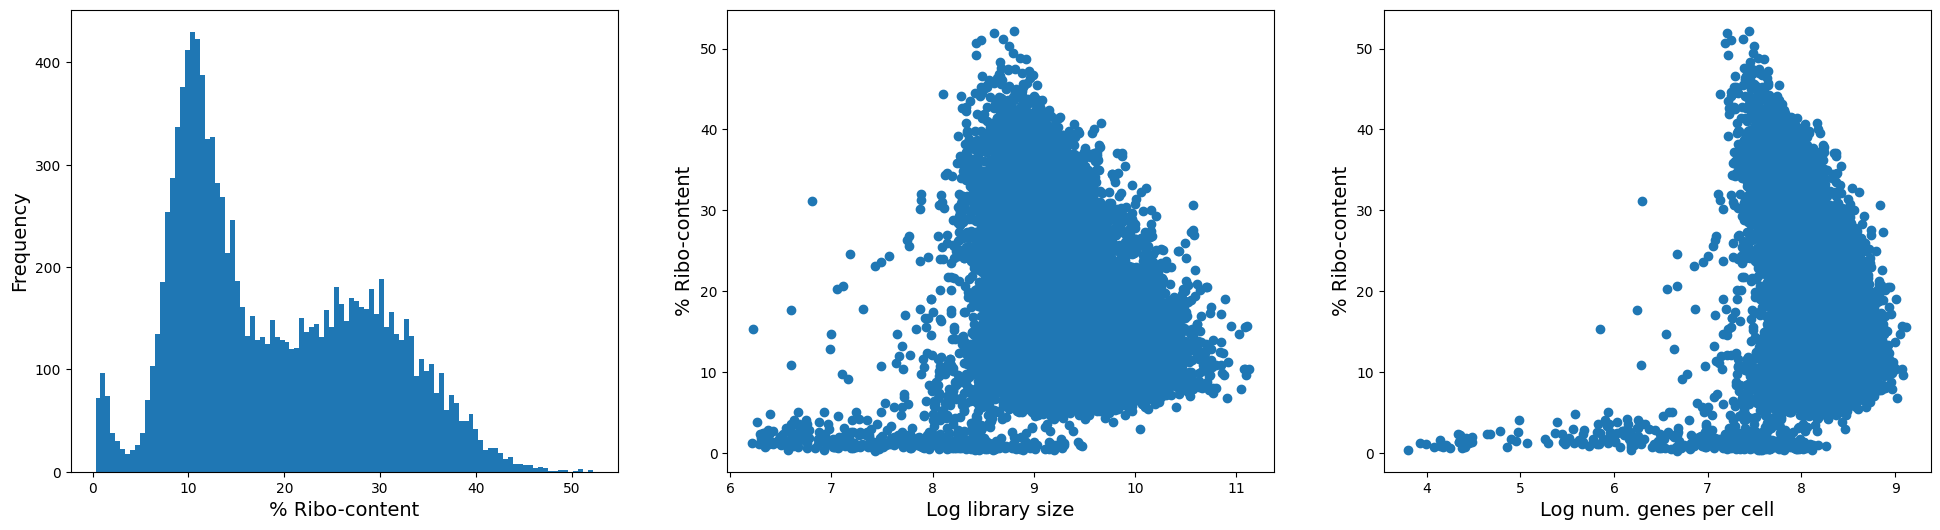

In [30]:
fig = plt.figure(figsize = (8*3, 6*1))
ax = fig.add_subplot(1, 3, 1)
ax.hist(adata.obs['ribo_pct_content'], 100);
ax.set_xlabel('% Ribo-content', fontsize = 14)
ax.set_ylabel('Frequency', fontsize = 14)

ax = fig.add_subplot(1, 3, 2)
ax.scatter(adata.obs['log1p_total_counts'], adata.obs['ribo_pct_content']);
ax.set_xlabel('Log library size', fontsize = 14)
ax.set_ylabel('% Ribo-content', fontsize = 14)

ax = fig.add_subplot(1, 3, 3)
ax.scatter(adata.obs['log1p_n_genes_by_counts'], adata.obs['ribo_pct_content']);
ax.set_xlabel('Log num. genes per cell', fontsize = 14)
ax.set_ylabel('% Ribo-content', fontsize = 14)

## (Optional but often recommended) Remove ribosomal genes

Many publications often remove ribosomal genes from the beginning of their analysis because there are very limited publications which highlight their important application beisdes cell homeostasis. Here is an example of code of how you can remove ribosomal genes from your data: 

In [31]:
adata_clean = adata[:, ~adata.var_names.str.startswith(('RPS', 'RPL'))]

In [32]:
adata

AnnData object with n_obs × n_vars = 11984 × 17698
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [33]:
adata_clean

View of AnnData object with n_obs × n_vars = 11984 × 17601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

NOTE: For the sake of exposition, we will continue with original `adata` (i.e. will not use `adata_clean`).

## Doublet score

Let us estimate the amount of doublets in the dataset. Here, we use the tool `scrublet` that simulates doublet gene expression profiles based on the data. We apply it for each sample separately.

In [38]:
# filtering/preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters:
expected_doublet_rate = 0.02 
sim_doublet_ratio = 3
n_neighbors = 15



scrub = scr.Scrublet(counts_matrix = adata.X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)

doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts = min_counts, 
                    min_cells = min_cells, 
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True, 
                    get_doublet_neighbor_parents = False)

adata.obs['doublet_score'] = doublet_scores
adata.obs['doublet'] = predicted_doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 2.1%
Estimated detectable doublet fraction = 35.0%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 5.9%
Elapsed time: 43.7 seconds


**Tasks:** Plot the doublet score as a histogram and as violin plot. 

In [ ]:
rcParams['figure.figsize']=(6,6)
sb.distplot() #histogram of the doublet score
plt.show()

rcParams['figure.figsize']=(15,7)
sc.pl.violin() #violin plot of the doublet score

### Filtering doublets  

Scrublet proposed a different threshold than we would choose based upon the histogram plot of the doublet scores.

**Tasks:** Decide on a threshold to filter doublets. 

In [ ]:
thr = #add threshold
ix_filt = adata.obs['doublet_score']<=thr

adata = adata[ix_filt].copy()
print('Number of cells after doublet filter: {:d}'.format(adata.n_obs))

# Data Normalization

One of the most common normalization methods is median library size normalization followed by log-transformation. Median library size normalization is inspired from normalization techniques in bulk data (Transcript Per Million or TPM normalization). This approach aims to normalize the library size of all cells to the same value, which is usually set to be the median library size in the data. The assumption here is that all cells in a sample should have the same total number of RNA counts. Obviously this is not necessarily an adequate assumption and in many circumstances is false (for example, a sample with cells of different sizes or at different stages of activation can have different total RNA). However, this is still the most common kind of normalization being used.

The normalization step is followed by a log transformation of the data. This step is done primarily to normalize for the differences in gene expression scales. Of note, scRNA-seq data is massively undersampled, which means many of the entries are 0 thus taking log of the data can be problematic. As such, it is typical to add a non-zero pseudocount (typically 0.1 or 1) to the data. It is generally wise to ensure that zeros remain as zeros post log-transformation. So, it is common to add 1 to the data before taking log of the data: `adata.X = np.log(adata.X + 1)` or adding and subtracting 0.1: `adata.X = np.log(adata.X + 0.1) - np.log(0.1)`. Either way, zeros before log remain as zeros.

Before we apply this normalization step, one very important note on Scanpy's data structure: The main data on which processing is to be done is stored in `adata.X`. So if we normalize the data in place then the original raw data will be replaced by the new normalized counts and we will lose the original counts. To avoid this from happening, we will store the original raw counts in adata.layers as follows. It is wise to save original counts for later, as we may require them for downstream analysis (e.g. count based factor analysis methods).

In [39]:
adata.layers['raw_data'] = adata.X.copy()

Now that we have made a copy of the original counts, we can go ahead and apply Scanpy's normalization function.

In [40]:
sc.pp.normalize_total(adata, inplace = True)

We can now log transform the data as follows (Note - we did not save normalized data in layers as raw_data because we can always recompute it if needed):

In [41]:
sc.pp.log1p(adata)

# Save results for future

In [44]:
adata

AnnData object with n_obs × n_vars = 11984 × 17698
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content', 'doublet_score', 'doublet'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'
    layers: 'raw_data'

In [45]:
adata.write_h5ad(input_path + 'processed/processed_data.h5ad')

# Loading saved data

In [46]:
adata = sc.read_h5ad(input_path + 'processed/processed_data.h5ad')

In [47]:
adata

AnnData object with n_obs × n_vars = 11984 × 17698
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_pct_content', 'ribo_pct_content', 'doublet_score', 'doublet'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'
    layers: 'raw_data'